# QCoDeS tutorial 
This notebook was made to accompany 160703_qcodes_tutorial.pptx but should serve as a self standing example. 

The tutorial is aimed at explaining basic qcodes use. 





## Typical QCodes workflow 
1. Start up an interactive python session (e.g. using jupyter) 
2. import desired modules 
3. instantiate required instruments 
4. experiment! 

Note that step 4 (experiment) often involves defining custom loops, plotting and analyzing data, and testing new instruments. 
**The user *is* the programmer. **




## Import desired modules (including qcodes as qc) 

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from pprint import pprint
import time
import numpy as np


import qcodes as qc

qc.set_mp_method('spawn')  # force Windows behavior on mac

# this makes a widget in the corner of the window to show and control
# subprocesses and any output they would print to the terminal
qc.show_subprocess_widget()



<IPython.core.display.Javascript object>

## Instantiates all the instruments needed for the demo

In [2]:
# spawn doesn't like function or class definitions in the interpreter
# session - had to move them to a file.
from toymodel import AModel, MockGates, MockSource, MockMeter, AverageGetter, AverageAndRaw

# now create this "experiment", note that all these are instruments 
model = AModel()
gates = MockGates('gates', model=model)
source = MockSource('source', model=model)
meter = MockMeter('meter', model=model)

# The station is a container for all instruments that makes it easy 
# to log meta-data
station = qc.Station(gates, source, meter)

# it's nice to have the key parameters be part of the global namespace
# that way they're objects that we can easily set, get, and slice
c0, c1, c2, vsd = gates.chan0, gates.chan1, gates.chan2, source.amplitude

# once we have implemented a monitor, defining a station will start a
# DataServer process, and you would see it in the subprocess widget,
# or via active_children() as here:
# qc.active_children()

### The location provider can be set globally 

In [3]:
# dm = qc.data.manager.get_data_manager()
loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

# Running an experiment 

### Defining the `Loop` and actions

Before you run a measurement loop you do two things:
1. You describe what parameter(s) to vary and how. This is the creation of a `Loop` object: `loop = Loop(sweep_values, ...)`
2. You describe what to do at each step in the loop. This is `loop.each(*actions)` which converts the `Loop` object into an `ActiveLoop` object. Actions can be:
  - measurements (any object with a `.get` method will be interpreted as a measurement)
  - `Task`: some callable (which can have arguments with it) to be executed each time through the loop. Does not generate data.
  - `Wait`: a specialized `Task` just to wait a certain time.
  - `BreakIf`: some condition that, if it returns truthy, breaks (this level of) the loop
  - Another `ActiveLoop` to nest inside the outer one.

For more details, see issue #232 docs: Write bigger picture

Data is DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2016-08-25/#031_{name}_16-41-22'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Setpoint | gates_chan0_set | chan0        | (401,)
   Measured | meter_amplitude | amplitude    | (401,)


<IPython.core.display.Javascript object>


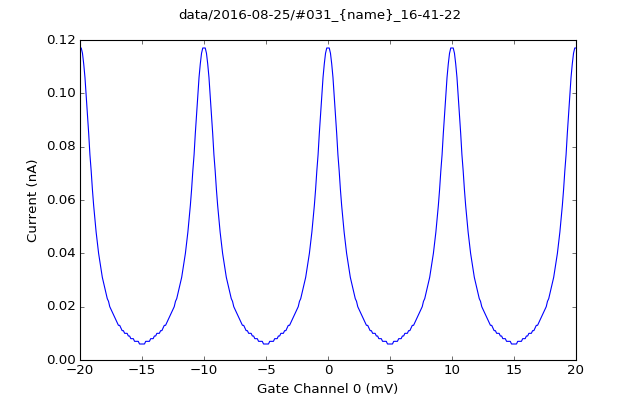

DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2016-08-25/#031_{name}_16-41-22'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Setpoint | gates_chan0_set | chan0        | (401,)
   Measured | meter_amplitude | amplitude    | (401,)
started at 2016-08-25 16:41:46


DataSet:
   mode     = DataMode.LOCAL
   location = 'data/2016-08-25/#031_{name}_16-41-22'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Setpoint | gates_chan0_set | chan0        | (401,)
   Measured | meter_amplitude | amplitude    | (401,)

In [7]:
# Notice that one can use an explicit location and `overwrite=True` here so that
# running this notebook over and over won't result in extra files.
# If you leave these out, you get a new timestamped DataSet each time.

# data = qc.Loop(c0.sweep(-20,20,0.1), delay=0.003).each(meter.amplitude).run(location='testsweep', overwrite=True)
loop = qc.Loop(c0.sweep(-20,20,0.1), delay=0.01).each(meter.amplitude)
data = loop.get_data_set(data_manager=False, write_period=None)
print('Data is %r' % data)
#plot = qc.QtPlot()
plot = qc.MatPlot()
plot.add(data.meter_amplitude)
def bg():
    #data.sync()
    plot.update_bg()
    pass
loop.with_bg_task(bg, 0.0005).run(name='testsweep',background=False)
#loop.run(name='testsweep',background=False,location=False)

# There should be two extra processes running, DataServer and a sweep 
# this should be visible in the subproces_widget or by calling qc.active_children()

## Output of the loop
Notice the **"DataSet"**.  
A loop returns a dataset.  
The representation of the dataset shows what arrays it contains and where it is saved.   
The dataset initially starts out empty (filled with NAN's) and get's filled while the Loop get's executed. 

By calling data.sync() the copy in the notebook get's synchronized with the copy on the dataserver


In [ ]:
# manually bring the data into the main process and display it as numbers
data.sync()
# data.arrays  

Once the measurement is done, take a look at the file in finder/explorer (the dataset.location should give you the relative path). 
Note also the snapshot that captures the settings of all instruments at the start of the Loop. 

This metadata is also accesible from the dataset and captures a snapshot of each instrument listed in the station. 

In [ ]:
meter.snapshot()

In [ ]:
# Commented out to keep the notebook readable, feel free to uncomment and see what comes out
# pprint(data.metadata)

## Plotting the loop 
Because the dataset contains all the required meta-data plotting is trivial.  
I consider it good practice to reuse the plot monitor but that's a personal style thing. 


In [ ]:
# live-updating plot, that syncs the data and stops updating when it's finished

# QCodes supports both matplotlib and pyqtgraph for plotting. 
# for a comparison see http://pyqtgraph.org/ (actually not that biased)
# plot = qc.MatPlot(data.meter_amplitude)


# I consider it good practice to instantiate the plotting monitor once 
# and then keep reusing it. 
plotQ = qc.QtPlot()
plotQ.add(data.meter_amplitude)




In [ ]:
# It may be that live plotting is not working on your system (see #259)
# Below is a snippet that serves as a workaround, this will be removed upon closing #259

# while data.sync():
#     plotQ.update()
# plotQ.update()

## Example: multiple 2D measurements 

In [ ]:
data2 = qc.Loop(c1[-15:15:1], 0.01).loop(c0[-15:12:.5], 0.001).each(
    meter.amplitude, # first measurement, at c2=0 -> amplitude_0 bcs it's action 0
    qc.Task(c2.set, 1), # action 1 -> c2.set(1)
    qc.Wait(0.001),
    meter.amplitude, # second measurement, at c2=1 -> amplitude_4 bcs it's action 4
    qc.Task(c2.set, 0)
    ).run(name='2D_test')

# use the subplot and add features of qc.MatPlot
# plot2 = qc.MatPlot(data2.meter_amplitude_0, cmap=plt.cm.hot, figsize=(12, 4.5), subplots=(1, 2))
# plot2.add(data2.meter_amplitude_3, cmap=plt.cm.hot, subplot=2)

# the equivalent in QtPlot
# by clearing the old window it can be reused
plotQ.clear() 
plotQ.add(data2.meter_amplitude_0, figsize=(1200, 500))
plotQ.add(data2.meter_amplitude_3, subplot=2)          

## Example same outer loop, different inner loop 

In [ ]:
data3 = qc.Loop(c1[-15:15:1], 0.1).each(
    qc.Task(c0.set, -10),
    qc.Task(c2.set, 0),
    # a 1D measurement
    meter.amplitude,
    # a 2D sweep, .each is actually unnecessary bcs this is the default measurement
    qc.Loop(c0[-15:15:1], 0.001).each(meter.amplitude),
    qc.Task(c0.set, -10),
    # a 2D sweep with the same outer but different inner loop
    qc.Loop(c2[-10:10:0.2], 0.001).each(meter.amplitude),
    AverageGetter(meter.amplitude, c2[-10:10:0.2], 0.001)
).run(name='TwoD_different_inner_test')

# several plots updating simultaneously
# plot3 = qc.MatPlot(data3.meter_amplitude_3_0, cmap=plt.cm.hot)
# plot3b = qc.MatPlot(data3.meter_amplitude_5_0, cmap=plt.cm.hot, figsize=(12, 4.5), subplots=(1,2))
# plot3b.add(data3.meter_avg_amplitude, subplot=2)
plotQ.clear()
plotQ.add(data3.meter_amplitude_3_0)
plotQ.add(data3.meter_amplitude_5_0, cmap='viridis', subplot=2)
plotQ.add(data3.meter_avg_amplitude, subplot=3)

### Example 2D scan and average

In [ ]:
# An example of a parameter that returns several values of different dimension
# This produces the last two arrays from data3, but only takes the data once.
data4 = qc.Loop(c1[-15:15:1], 0.01).each(
    AverageAndRaw(meter.amplitude, c2[-10:10:0.2], 0.001)
).run(name='TwoD_average_test')

# plot4 = qc.MatPlot(data4.meter_amplitude, cmap=plt.cm.hot, subplots=(1,2), figsize=(12, 4.5))
# plot4.add(data4.meter_avg_amplitude, subplot=2)

plotQ.clear()
plotQ.add(data4.meter_amplitude, figsize=(1200, 500), cmap='viridis')
plotQ.add(data4.meter_avg_amplitude, subplot=2)

# Data analysis, loading old data 

`DataSet` objects are not intended to be instantiated directly, but
rather through the helper functions:
- `load_data` for existing data sets, including the data currently
  being acquired.
- `new_data` to make an empty data set to be populated with new
  measurements or simulation data. `new_data` is called internally by
  `Loop.run()` so is also generally not needed directly.

If you omit `location`, or if `location` matches the data set currently
being acquired, `load_data` and subsequent calls to `data_set.sync()`
will pull from the `DataServer` (`DataMode.PULL_FROM_SERVER`).
Otherwise `load_data` and `data_set.sync()` will read from disk
(`DataMode.LOCAL`).

Note that a `DataServer` is, at least for now, local to one parent
process / notebook, so if you open a separate notebook for analysis, even
your live data will be pulled from disk.

In [ ]:
# Use the location of a file created earlier this session
location = data3.location 
print(location)
data = qc.load_data(location=location)

In [ ]:
data

In [ ]:
plotQ.clear()
plotQ.add(data.meter_avg_amplitude)